# PROYECTO INDIVIDUAL Nº1

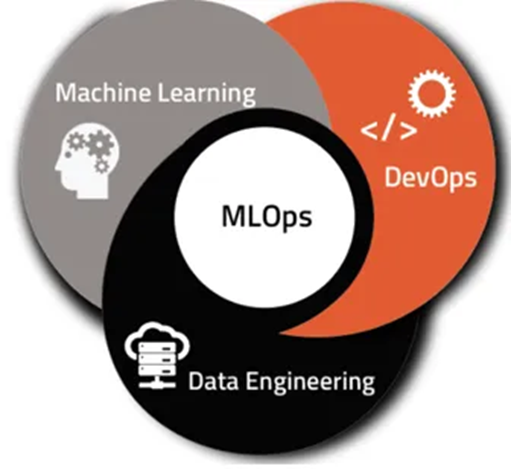

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import json
import ast
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import calendar
import fastparquet

Carga de Datos

In [169]:
credits_df = pd.read_csv(r'C:\Users\claud\OneDrive\Escritorio\Henry 1erPI-ML\Bases de Datos Original\credits.csv')
movies_df = pd.read_csv(r'C:\Users\claud\OneDrive\Escritorio\Henry 1erPI-ML\Bases de Datos Original\movies_dataset.csv', low_memory=False)

Revisión de los datos

In [170]:
# Verificación inicial
print(movies_df.head())
print(credits_df.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

Eliminar duplicados

In [171]:
movies_df = movies_df.drop_duplicates()
credits_df = credits_df.drop_duplicates()


Eliminar columnas innecesarias

In [172]:
columnas_a_eliminar = ['adult', 'homepage', 'imdb_id', 'original_language', 'original_title', 'poster_path', 'video', 'tagline']
movies_df = movies_df.drop(columns=columnas_a_eliminar)

Eliminar valores nulos

In [173]:
movies_df.dropna(subset=['release_date', 'overview', 'popularity', 'production_companies', 'production_countries', 'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'vote_average', 'vote_count'], inplace=True)


Filtrar solo las películas que han sido lanzadas

In [174]:
movies_df = movies_df.loc[movies_df['status'] == 'Released']
movies_df = movies_df.drop(columns='status')

Transformar Datos

Se rellena los valores nulos en revenue y budget

In [175]:
movies_df['revenue'] = movies_df['revenue'].fillna(0)
movies_df['budget'] = movies_df['budget'].fillna(0)

Se realiza una converción en los números para futuros cálculos

In [176]:
movies_df['id'] = movies_df['id'].astype('int64')
movies_df['budget'] = movies_df['budget'].astype('int')
movies_df['vote_count'] = movies_df['vote_count'].astype('int')
movies_df['revenue'] = movies_df['revenue'].astype('int')
movies_df['runtime'] = movies_df['runtime'].astype('float')

Se convierte la fecha y se crea la columna release_year

In [177]:
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.strftime('%Y-%m-%d')
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year


Se crea la columna return (revenue / budget)

In [178]:
def calculate_roi(row):
    revenue = row['revenue']
    budget = row['budget']
    return revenue / budget if budget != 0 else 0

movies_df['return'] = movies_df.apply(calculate_roi, axis=1)

Se procede a desanidar las columnas

- Se desanida movies_df

In [179]:
print(movies_df.columns)


Index(['belongs_to_collection', 'budget', 'genres', 'id', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'title',
       'vote_average', 'vote_count', 'release_year', 'return'],
      dtype='object')


In [180]:
import pandas as pd
import ast

def expand_columns(df, columns):
    for column in columns:
        # Convertir cada cadena en lista de diccionarios si es necesario
        df[column] = df[column].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
        
        # Explode para crear nuevas filas
        df = df.explode(column)
        
        # Desanidar los diccionarios en columnas individuales
        col_df = pd.json_normalize(df[column])
        
        # Añadir prefijos a las nuevas columnas
        col_df = col_df.add_prefix(f'{column}_')
        
        # Unir el DataFrame original con las nuevas columnas
        df = df.drop(columns=[column]).reset_index(drop=True).join(col_df)
    return df

# Columnas que deseas desanidar
columns_to_expand = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'belongs_to_collection']

# Aplicar la función de desanidación
movies_df = expand_columns(movies_df, columns_to_expand)

# Revisión del DataFrame resultante
print(movies_df.head())


     budget   id                                           overview  \
0  30000000  862  Led by Woody, Andy's toys live happily in his ...   
1  30000000  862  Led by Woody, Andy's toys live happily in his ...   
2  30000000  862  Led by Woody, Andy's toys live happily in his ...   
3  30000000  862  Led by Woody, Andy's toys live happily in his ...   
4  30000000  862  Led by Woody, Andy's toys live happily in his ...   

  popularity release_date    revenue  runtime      title  vote_average  \
0  21.946943   1995-10-30  373554033     81.0  Toy Story           7.7   
1  21.946943   1995-10-30  373554033     81.0  Toy Story           7.7   
2  21.946943   1995-10-30  373554033     81.0  Toy Story           7.7   
3  21.946943   1995-10-30  373554033     81.0  Toy Story           7.7   
4  21.946943   1995-10-30  373554033     81.0  Toy Story           7.7   

   vote_count  release_year     return  genres_id genres_name  \
0        5415          1995  12.451801       16.0   Animation  

In [181]:
print(movies_df.columns)

Index(['budget', 'id', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'title', 'vote_average', 'vote_count', 'release_year',
       'return', 'genres_id', 'genres_name', 'production_companies_name',
       'production_companies_id', 'production_countries_iso_3166_1',
       'production_countries_name', 'spoken_languages_iso_639_1',
       'spoken_languages_name'],
      dtype='object')


Se desanida credit_df

Se realiza por separado ya que esto permitirá aplicar transformaciones específicas a cada conjunto de datos (actores y equipo) de manera más clara y eficiente.

In [182]:
# Verificar las columnas actuales
print(movies_df.columns)

Index(['budget', 'id', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'title', 'vote_average', 'vote_count', 'release_year',
       'return', 'genres_id', 'genres_name', 'production_companies_name',
       'production_companies_id', 'production_countries_iso_3166_1',
       'production_countries_name', 'spoken_languages_iso_639_1',
       'spoken_languages_name'],
      dtype='object')


In [183]:
credits_df_cast = credits_df[['cast', 'id']].copy()
credits_df_crew = credits_df[['crew', 'id']].copy()


Se expanden las columnas

In [184]:
columns_to_expand = ['cast']
credits_df_cast = expand_columns(credits_df_cast, columns_to_expand)

columns_to_expand = ['crew']
credits_df_crew = expand_columns(credits_df_crew, columns_to_expand)

Se eliminan los datos duplicados

In [185]:
movies_df = movies_df.drop_duplicates()
credits_df_cast = credits_df_cast.drop_duplicates()
credits_df_crew = credits_df_crew.drop_duplicates()

Veo las columnas que van quedando en las utlimas tranmsformaciones, para eliminar las que sean de poca utilidad

In [186]:
# Mostrar todas las columnas del DataFrame
print(movies_df.columns)

Index(['budget', 'id', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'title', 'vote_average', 'vote_count', 'release_year',
       'return', 'genres_id', 'genres_name', 'production_companies_name',
       'production_companies_id', 'production_countries_iso_3166_1',
       'production_countries_name', 'spoken_languages_iso_639_1',
       'spoken_languages_name'],
      dtype='object')


In [187]:
# Mostrar todas las columnas de df_credit_cast
print(credits_df_cast.columns)

# Mostrar todas las columnas de df_credit_crew
print(credits_df_crew.columns)


Index(['id', 'cast_cast_id', 'cast_character', 'cast_credit_id', 'cast_gender',
       'cast_id', 'cast_name', 'cast_order', 'cast_profile_path'],
      dtype='object')
Index(['id', 'crew_credit_id', 'crew_department', 'crew_gender', 'crew_id',
       'crew_job', 'crew_name', 'crew_profile_path'],
      dtype='object')


In [188]:
columnas_a_eliminar = ['genres_id', 'production_companies_id', 'production_countries_iso_3166_1', 'spoken_languages_iso_639_1']
movies_df = movies_df.drop(columns=columnas_a_eliminar)


In [189]:
credits_df_cast = credits_df_cast.drop(columns=['cast_cast_id', 'cast_credit_id', 'cast_gender', 'cast_id', 'cast_profile_path'])
credits_df_crew = credits_df_crew.drop(columns=['crew_credit_id', 'crew_department', 'crew_gender', 'crew_id', 'crew_profile_path'])


Se filtra Directores para trabajar exclusivamente con los directores y ya no tener información redundante sobre su rol en la película.

In [190]:
credits_df_crew = credits_df_crew[credits_df_crew['crew_job'] == 'Director']
credits_df_crew = credits_df_crew.drop(columns='crew_job')

Se filtra credit_df_cast para solo usar las filas donde el valor de cast_order está en el rango de 1 a 5, manteniendo solo a los primeros cinco actores en el orden de créditos.

In [191]:
credits_df_cast = credits_df_cast[credits_df_cast['cast_order'] <= 5]

Se guardan los DataFrames limpios

Finalmente, se guarda los DataFrames limpiados en formato Parquet 

In [192]:
import os

# Crear la carpeta ETL_Parquet si no existe
os.makedirs('ETL_Parquet', exist_ok=True)

In [193]:
# Guardar los DataFrames en formato Parquet dentro de la carpeta ETL
movies_df.to_parquet('ETL_Parquet/movies_cleaned.parquet', index=False)
credits_df_cast.to_parquet('ETL_Parquet/credit_cast_cleaned.parquet', index=False)
credits_df_crew.to_parquet('ETL_Parquet/credit_crew_cleaned.parquet', index=False)

In [197]:
columns_to_expand = ['production_companies', 'production_countries', 'spoken_languages', 'belongs_to_collection']

In [198]:
import pandas as pd

# Cargar los archivos Parquet con las rutas corregidas
credits_cast_df = pd.read_parquet(r'C:\Users\claud\OneDrive\Escritorio\Henry 1erPI-ML\ETL\ETL_Parquet\credit_cast_cleaned.parquet')
credits_crew_df = pd.read_parquet(r'C:\Users\claud\OneDrive\Escritorio\Henry 1erPI-ML\ETL\ETL_Parquet\credit_crew_cleaned.parquet')
movies_df = pd.read_parquet(r'C:\Users\claud\OneDrive\Escritorio\Henry 1erPI-ML\ETL\ETL_Parquet\movies_cleaned.parquet')

# Verificación inicial de los DataFrames
print(credits_cast_df.head())
print(credits_crew_df.head())
print(movies_df.head())

    id           cast_character      cast_name  cast_order
0  862            Woody (voice)      Tom Hanks         0.0
1  862   Buzz Lightyear (voice)      Tim Allen         1.0
2  862  Mr. Potato Head (voice)    Don Rickles         2.0
3  862       Slinky Dog (voice)     Jim Varney         3.0
4  862              Rex (voice)  Wallace Shawn         4.0
      id        crew_name
0    862    John Lasseter
1   8844     Joe Johnston
2  15602    Howard Deutch
3  31357  Forest Whitaker
4  11862    Charles Shyer
     budget    id                                           overview  \
0  30000000   862  Led by Woody, Andy's toys live happily in his ...   
1  30000000   862  Led by Woody, Andy's toys live happily in his ...   
2  30000000   862  Led by Woody, Andy's toys live happily in his ...   
3  65000000  8844  When siblings Judy and Peter discover an encha...   
4  65000000  8844  When siblings Judy and Peter discover an encha...   

  popularity release_date    revenue  runtime      title 